# <font color=darkred>Simulation of Mixtures of Compressed Recycled Materials in Mars to Find their Compressive Strength</font>

## NASA Space Apps Challenge
## Date: October 4-5th, 2025
## Red PlaNet Team Contributors:
### Rivas, Andrés
### Garro, Daniela
### Hidalgo, Diego
### Shih, Danny
### Xirinachs, Manfred
___

In [83]:
# Preamble script block to identify host, user, and kernel
import sys
! hostname
! whoami
print(sys.executable)
print(sys.version)
print(sys.version_info)

Danny-SG-Laptop
danny-sg-laptop\dshih
C:\Users\dshih\anaconda3\python.exe
3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
sys.version_info(major=3, minor=12, micro=7, releaselevel='final', serial=0)


## 1. If you have not, please install the necessary library by running the following command in order to later import them into the Jupyter notebook:
If you already have it installed, you can skip this step or still run the commands. They will output whether it is already installed, missing, or failed to install (perhaps if you do not have sufficient access to the internet or have software incompatibility).

In [84]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


## 2. Import the necessary libraries, packages, and modules we will be using:

In [85]:
import matplotlib.pyplot as plt # for visual graphing
import numpy as np # for math operations in larger data sets such as (re-)sampling
import pandas as pd # for reading the Compressive Strength Data file as a data frame and extracting metrics from its data
import scipy # for distribution statistic
import seaborn as sns # for extended graphing operations aside of plt
# Scikit-Learn modules and functions for the Compressive Strength Prediction model training and metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm # stats for the Compressive Strength prediction model
import statistics # General purpose statistics

## 3. Sympy math explanations of data process:

In [86]:
# Sympy for math operations and symbols
from sympy.abc import i, m, n, j, alpha
from sympy import symbols, Sum, Eq, Rational, Function, UnevaluatedExpr, exp

# -------------------------
# Define symbols
# -------------------------
# f_i = mass fraction of component i
# x_i = property of component i (generic)
# rho_i = density of component i
# E_i = Young's modulus of component i
# K_i = Bulk modulus of component i
f_i, x_i, rho_i, E_i, K_i = symbols('f_i x_i rho_i E_i K_i')

# Mixture properties
X_mix, rho_mix, E_mix, K_mix = symbols('X_mix rho_mix E_mix K_mix')

# 16 possible materials:
# Resealable bags (LDPE (C₂H₄)ₙ)
# Nitrile gloves
# Nomex
# Cotton
# Cellulose (pure)
# Nylon
# Polyester
# Overwrap
# Polyethylene
# Polymer matrix
# Carbon fiber
# Plastic resin
# Bubble wrap
# Anti-static bubble wrap
# Plastazote foam
# Bulk Soil MGS-1 Mars Global Simulant (with porosity ~0.44) (

# -------------------------
# 1️⃣ Average Density
# -------------------------
# Weighted average of component densities by mass fraction
rho_mix_expr = Eq(rho_mix, Sum(f_i * rho_i, (i, 1, n)))
"""
The 16 components listed above would be replaced instead of n, but this formula was used
initially for calculating E and K for MGS-1 using its 11 chemical compounds, note that
we already have the average density of the MGS-1 and we can deduce a porosity factor of 0.44
to adjust the mismatch of average density in our calculation and match that to the E and K moduli
"""
display(rho_mix_expr)
print("Explanation: Weighted average of component densities by mass fraction.")

# -------------------------
# 2️⃣ Young's Modulus and Bulk Modulus
# -------------------------
# Weighted sum approach for mixture properties
E_mix_expr = Eq(E_mix, Sum(f_i * E_i, (i, 1, n)))
K_mix_expr = Eq(K_mix, Sum(f_i * K_i, (i, 1, n)))
display(E_mix_expr)
display(K_mix_expr)
print("Explanation: Mixture modulus computed as weighted sum of component moduli.")

# -------------------------
# 3️⃣ Porosity adjustment (if applicable)
# -------------------------
# Porosity factor phi = fraction of voids; 0 <= phi <= 1
phi = symbols('phi')
E_effective = Eq(E_mix, (1 - phi) * E_mix)  # reduce modulus by porosity
K_effective = Eq(K_mix, (1 - phi) * K_mix)
rho_effective = Eq(rho_mix, (1 - phi) * rho_mix)
display(E_effective)
display(K_effective)
display(rho_effective)
print("Explanation: Adjust for porosity by multiplying by solid fraction (1 - phi).")

# -------------------------
# 4️⃣ Maximum Compressive Strength
# -------------------------
# σ_max is proportional to modulus and density
sigma_max = symbols('σ_max')
sigma_max_expr = Eq(sigma_max, Rational(1,20) * E_mix * rho_mix)  # scaling factor 0.05
display(sigma_max_expr)
print("Explanation: Maximum achievable compressive strength is scaled by E_mix and rho_mix.")

# -------------------------
# 5️⃣ Compressive Strength Saturating Function
# -------------------------
# σ_c = σ_max * (1 - exp(-α * P * t))
alpha, P, t = symbols('α P t')  # saturation factor, applied pressure, press time
sigma_c = symbols('σ_c')
sigma_c_expr = Eq(sigma_c, sigma_max * (1 - exp(-alpha * P * t)))
display(sigma_c_expr)
print("Explanation: Compressive strength increases with pressure and press time")
print("             but saturates at σ_max following an exponential growth relation.")

# Optional: show full combined formula
sigma_c_full = Eq(sigma_c, Rational(1,20) * E_mix * rho_mix * (1 - exp(-alpha * P * t)))
display(sigma_c_full)
print("Explanation: Full formula combining σ_max and the saturating exponential function.")

# -------------------------
# Nonlinear Gradient Descent Algorithm Explanation
# -------------------------

# Define symbols
theta_j, theta, P, t, rho_mix, sigma_max = sp.symbols('theta_j theta P t rho_mix sigma_max')
x_j_i, x_i, y_i = sp.symbols('x_j^(i) x^(i) y^(i)')
h_theta = sp.Function('h_theta')
J = sp.Function('J')

# -----------------------------
# 1️⃣ Hypothesis function (Nonlinear saturating)
# -----------------------------
# For simplicity, represent linear combination: z^(i) = theta^T * x^(i)
z_i = sp.Symbol('z^(i)')
h = sigma_max * sp.log(1 + sp.exp(z_i))  # softplus approximation
eq_h = sp.Eq(h_theta(x_i), h)
print("Hypothesis function (Nonlinear Softplus/Saturation):")
display(eq_h)

# -----------------------------
# 2️⃣ Cost function (MSE)
# -----------------------------
sum_expr = sp.Sum((h_theta(x_i) - y_i)**2, (i, 1, m))
eq_J = sp.Eq(J(theta), (1/(2*m)) * sum_expr)
print("Cost function (Mean Squared Error):")
display(eq_J)

# -----------------------------
# 3️⃣ Gradient of cost w.r.t theta_j
# -----------------------------
grad_expr = sp.Sum((h_theta(x_i) - y_i) * sp.diff(h_theta(x_i), theta_j), (i, 1, m))
partialJ_theta_j = sp.Symbol('∂J/∂θ_j')
eq_grad = sp.Eq(partialJ_theta_j, (1/m) * grad_expr)
print("Gradient of the cost function w.r.t θ_j:")
display(eq_grad)

# -----------------------------
# 4️⃣ Update rule (Gradient Descent)
# -----------------------------
theta_j_new = sp.Symbol('θ_j^{new}')
eq_update = sp.Eq(theta_j_new, theta_j - alpha * partialJ_theta_j)
print("Gradient descent update rule:")
display(eq_update)

Eq(rho_mix, Sum(f_i*rho_i, (i, 1, n)))

Explanation: Weighted average of component densities by mass fraction.


Eq(E_mix, Sum(E_i*f_i, (i, 1, n)))

Eq(K_mix, Sum(K_i*f_i, (i, 1, n)))

Explanation: Mixture modulus computed as weighted sum of component moduli.


Eq(E_mix, E_mix*(1 - phi))

Eq(K_mix, K_mix*(1 - phi))

Eq(rho_mix, rho_mix*(1 - phi))

Explanation: Adjust for porosity by multiplying by solid fraction (1 - phi).


Eq(σ_max, E_mix*rho_mix/20)

Explanation: Maximum achievable compressive strength is scaled by E_mix and rho_mix.


Eq(σ_c, σ_max*(1 - exp(-P*t*α)))

Explanation: Compressive strength increases with pressure and press time
             but saturates at σ_max following an exponential growth relation.


Eq(σ_c, E_mix*rho_mix*(1 - exp(-P*t*α))/20)

Explanation: Full formula combining σ_max and the saturating exponential function.
Hypothesis function (Nonlinear Softplus/Saturation):


Eq(h_theta(x^(i)), sigma_max*log(exp(z^(i)) + 1))

Cost function (Mean Squared Error):


Eq(J(theta), Sum((-y^(i) + h_theta(x^(i)))**2, (i, 1, m))/(2*m))

Gradient of the cost function w.r.t θ_j:


Eq(∂J/∂θ_j, Sum(0, (i, 1, m))/m)

Gradient descent update rule:


Eq(θ_j^{new}, theta_j - α*∂J/∂θ_j)

## 4. Calculations: Perform randomized possible E and K values depending on materials with replacement and calculating the compressive strength of the recycled mixtures as a database

In [87]:
# ------------------------
# 1️⃣ Define materials and fixed average densities (g/cm³)
# ------------------------
materials = [
    'Resealable bags (LDPE)', 'Nitrile gloves', 'Nomex', 'Cotton', 'Cellulose (pure)',
    'Nylon', 'Polyester', 'Overwrap', 'Polyethylene', 'Polymer matrix',
    # 'Carbon fiber',
    'Plastic resin', 'Bubble wrap', 'Anti-static bubble wrap',
    'Plastazote foam', 'Mars soil simulant'
]

avg_density = {
    'Resealable bags (LDPE)': 0.92, 'Nitrile gloves': 0.95, 'Nomex': 1.38,
    'Cotton': 1.54, 'Cellulose (pure)': 1.54, 'Nylon': 1.15, 'Polyester': 1.38,
    'Overwrap': 0.92, 'Polyethylene': 0.92, 'Polymer matrix': 1.225,
    #'Carbon fiber': 1.825,
    'Plastic resin': 1.225, 'Bubble wrap': 0.115,
    'Anti-static bubble wrap': 0.94, 'Plastazote foam': 0.115, 'Mars soil simulant': 1.29
}

# ------------------------
# 2️⃣ Define ranges for E (GPa) and K (GPa)
# ------------------------
ranges = {
    'E': {
        'Resealable bags (LDPE)': (0.2, 0.8),
        'Nitrile gloves': (0.01, 0.1),
        'Nomex': (3, 5),
        'Cotton': (8, 12),
        'Cellulose (pure)': (10, 15),
        'Nylon': (2, 3),
        'Polyester': (2, 2.7),
        'Overwrap': (0.3, 1.5),
        'Polyethylene': (0.2, 0.8),
        'Polymer matrix': (2, 5),
        # 'Carbon fiber': (200, 600),
        'Plastic resin': (2, 5),
        'Bubble wrap': (0.05, 0.1),
        'Anti-static bubble wrap': (0.05, 0.1),
        'Plastazote foam': (0.02, 0.2),
        'Mars soil simulant': (49.4, 49.4)  # constant
    },
    'K': {
        'Resealable bags (LDPE)': (2, 3),
        'Nitrile gloves': (0.05, 0.2),
        'Nomex': (4, 6),
        'Cotton': (7, 10),
        'Cellulose (pure)': (8, 12),
        'Nylon': (3, 5),
        'Polyester': (3, 5),
        'Overwrap': (2, 4),
        'Polyethylene': (2, 3),
        'Polymer matrix': (4, 8),
        # 'Carbon fiber': (30, 50),
        'Plastic resin': (4, 8),
        'Bubble wrap': (0.2, 0.5),
        'Anti-static bubble wrap': (0.2, 0.6),
        'Plastazote foam': (0.05, 0.3),
        'Mars soil simulant': (32.7, 32.7)  # constant
    }
}

# Applied Pressure (MPa) and Press Time (hours)
pressure_range_MPa = (1, 50)  # MPa
press_time_range_hours = (0.001, 1)  # 0.001 h ≈ 3.6 s to 1 h

# Wt% random sampling
wt_range = (0.0, 1.0)

# Number of synthetic samples
n_samples = 1000

# Saturation sensitivity factor
alpha = 0.01  # adjust to control saturation rate

# ------------------------
# 3️⃣ Generate synthetic dataset
# ------------------------
data = []

for _ in range(n_samples):
    # Sample wt% for each material, then normalize to sum to 1
    wt = np.random.uniform(*wt_range, size=len(materials))
    wt /= wt.sum()
    
    # Sample E and K for each material
    E_sample = [np.random.uniform(*ranges['E'][mat]) for mat in materials]
    K_sample = [np.random.uniform(*ranges['K'][mat]) for mat in materials]
    
    # Compute mixture-level properties
    E_mix = np.sum(np.array(E_sample) * wt)          # GPa
    K_mix = np.sum(np.array(K_sample) * wt)          # GPa
    rho_mix = np.sum(np.array([avg_density[mat] for mat in materials]) * wt)  # g/cm³
    
    # Convert E_mix to MPa
    E_mix_MPa = E_mix * 1000  # 1 GPa = 1000 MPa
    
    # Sample Applied Pressure and Press Time
    P = np.random.uniform(*pressure_range_MPa)      # MPa
    t = np.random.uniform(*press_time_range_hours)  # hours
    
    # ------------------------
    # Compute Compressive Strength (MPa) using saturating formula
    # ------------------------

    # Base compressive strength limit (scaled)
    sigma_max = 0.05 * E_mix_MPa * rho_mix  # scaling factor for realistic magnitude
    
    # Saturating growth with pressure and time
    sigma_c = sigma_max * (1 - np.exp(-alpha * P * t))
    
    # Append row
    data.append({
        'E_mix_GPa': E_mix,
        'K_mix_GPa': K_mix,
        'rho_mix_g_cm3': rho_mix,
        'Applied_Pressure_MPa': P,
        'Press_Hold_Time_hours': t,
        'Compressive_Strength_MPa': sigma_c
    })

# ------------------------
# 4️⃣ Create final DataFrame
# ------------------------
df_materials = pd.DataFrame(data)

print(df_materials.head())
print(df_materials.describe())

   E_mix_GPa  K_mix_GPa  rho_mix_g_cm3  Applied_Pressure_MPa  \
0   9.278653   7.545827       1.156509             21.475626   
1   5.205866   5.637345       1.070482             32.990316   
2   4.034806   4.197834       1.013748             43.130364   
3   8.630308   7.184718       0.979855             28.427137   
4   7.884567   6.856853       0.991116             37.744309   

   Press_Hold_Time_hours  Compressive_Strength_MPa  
0               0.104099                 11.861833  
1               0.418581                 35.939091  
2               0.437425                 35.162989  
3               0.470123                 52.893914  
4               0.738767                 95.079599  
         E_mix_GPa    K_mix_GPa  rho_mix_g_cm3  Applied_Pressure_MPa  \
count  1000.000000  1000.000000    1000.000000           1000.000000   
mean      5.910798     5.639310       1.039623             25.240191   
std       1.833016     1.180450       0.062937             14.203277   
min      

## 5. Define the Features and selecting the feature (input) rows and output row (compressive strength) from the dataframe

In [88]:
# Define the input and output variables
orig_i = df_materials.iloc[:, :5] # Select all original rows and index the independent variables
orig_cs = df_materials.iloc[:, 5] # Select all original rows of the dependent variable

## 6. Create the Nonlinear Gradient Descent Algorithm function using Softplus with a Model through a Training Set and Test Set 

Learned theta values:
 [[25.63584517]
 [ 9.76919861]
 [ 6.25133793]
 [ 2.03710726]
 [25.83654136]
 [27.91407457]]

Nonlinear Softplus Compressive Strength Equation:
 25.636 + (9.769 * x_1) + (6.251 * x_2) + (2.037 * x_3) + (25.837 * x_4) + (27.914 * x_5)


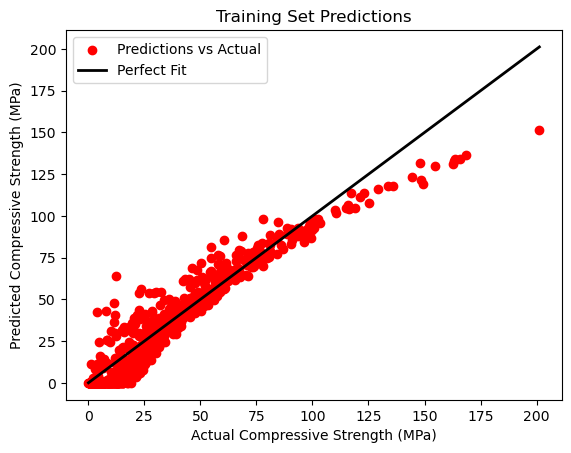

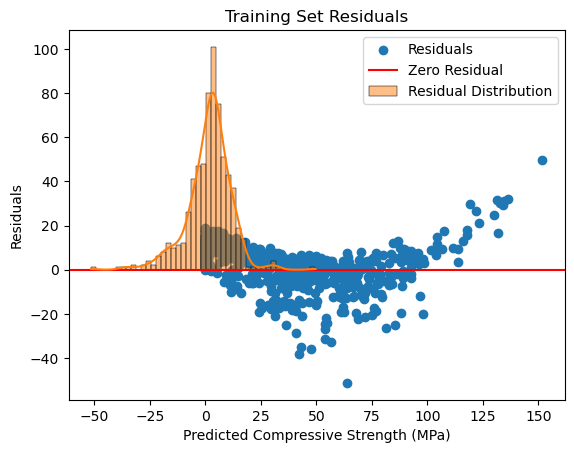

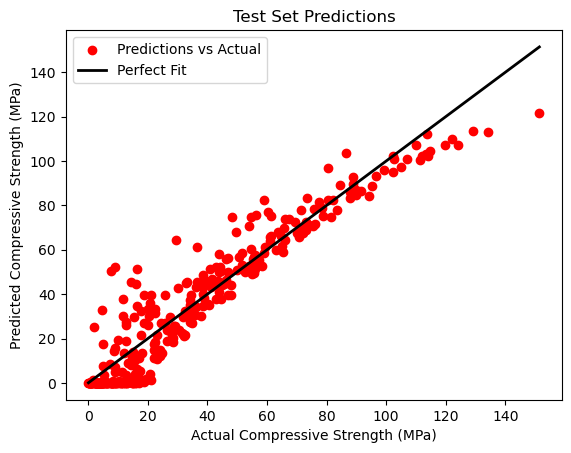

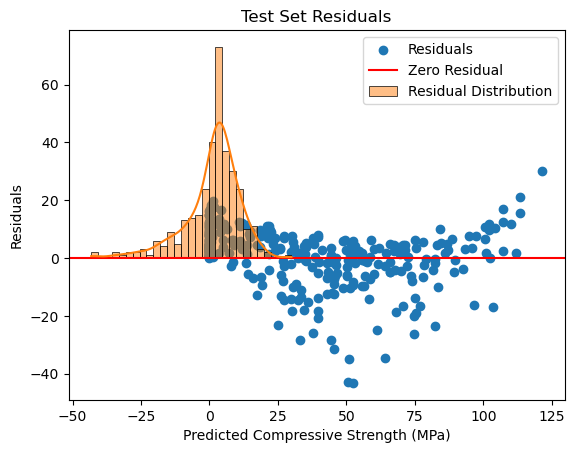

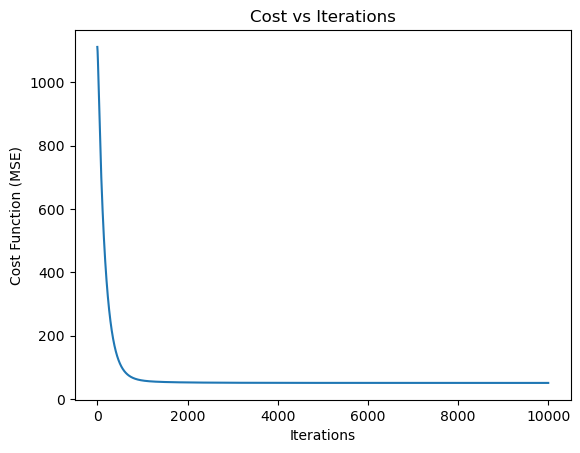

Training MSE: 100.5801228987297 R2: 0.90559218611471
Test MSE: 103.34623690623482 R2: 0.8976696346798577


In [89]:
# ------------------------
# Softplus activation and derivative
# ------------------------
def softplus(x):
    return np.log1p(np.exp(x))  # log(1 + e^x)

def softplus_grad(x):
    return 1 / (1 + np.exp(-x))  # derivative = sigmoid(x)

# ------------------------
# Prepare data
# ------------------------
# Assume df_materials has 5 features + 1 output column (column 5 is output)
features = df_materials.iloc[:, :5].values
output = df_materials.iloc[:, 5].values.reshape(1, -1)  # shape (1, n_samples)

# Split randomly into training and test sets
n_samples = features.shape[0]
idx = np.random.permutation(n_samples)
train_size = int(n_samples * 2 / 3)
train_idx = idx[:train_size]
test_idx = idx[train_size:]

i_train = features[train_idx, :]
i_test = features[test_idx, :]

cs_train = output[:, train_idx]  # shape (1, m_train)
cs_test = output[:, test_idx]    # shape (1, m_test)

# Standardize features
sc_i = StandardScaler()
i_train_scaled = sc_i.fit_transform(i_train)
i_test_scaled = sc_i.transform(i_test)

# Augment features with a row of ones for bias term
i_train_aug = np.vstack((np.ones((1, i_train_scaled.shape[0])), i_train_scaled.T))  # shape (6, m_train)
i_test_aug = np.vstack((np.ones((1, i_test_scaled.shape[0])), i_test_scaled.T))     # shape (6, m_test)

# ------------------------
# Initialize gradient descent
# ------------------------
theta = np.zeros((6, 1))  # 5 features + 1 bias
alpha = 0.003
num_iter = 10000
m_train = i_train_aug.shape[1]
costs = []

# ------------------------
# Gradient descent loop
# ------------------------
for _ in range(num_iter):
    linear_comb = np.transpose(theta) @ i_train_aug       # (1, m_train)
    h = softplus(linear_comb)                             # (1, m_train)
    error = h - cs_train                                  # (1, m_train)

    # Compute gradient correctly
    grad = (1 / m_train) * (i_train_aug * (error * softplus_grad(linear_comb)))  # (6, m_train)
    grad = grad.sum(axis=1, keepdims=True)  # (6,1)

    # Update theta
    theta -= alpha * grad

    # Compute cost
    J = (1 / (2 * m_train)) * np.sum(error ** 2)
    costs.append(J)

# ------------------------
# Display theta and equation
# ------------------------
print("Learned theta values:\n", theta)
eq = f"{theta[0,0]:.3f}"
for i in range(1, 6):
    eq += f" + ({theta[i,0]:.3f} * x_{i})"
print("\nNonlinear Softplus Compressive Strength Equation:\n", eq)

# ------------------------
# Predictions
# ------------------------
h_train = softplus(np.transpose(theta) @ i_train_aug)
h_test = softplus(np.transpose(theta) @ i_test_aug)

# ------------------------
# Training plots
# ------------------------
plt.figure()
plt.scatter(cs_train.flatten(), h_train.flatten(), color='r', label='Predictions vs Actual')
plt.plot([cs_train.min(), cs_train.max()],
         [cs_train.min(), cs_train.max()], color='black', lw=2, label='Perfect Fit')
plt.xlabel("Actual Compressive Strength (MPa)")
plt.ylabel("Predicted Compressive Strength (MPa)")
plt.title("Training Set Predictions")
plt.legend()
plt.show()

train_resid = cs_train - h_train
plt.figure()
plt.scatter(h_train.flatten(), train_resid.flatten(), label='Residuals')
plt.axhline(0, color='r', label='Zero Residual')
plt.xlabel("Predicted Compressive Strength (MPa)")
plt.ylabel("Residuals")
plt.title("Training Set Residuals")
plt.legend()
sns.histplot(train_resid.flatten(), kde=True, label='Residual Distribution')
plt.legend()
plt.show()

# ------------------------
# Test plots
# ------------------------
plt.figure()
plt.scatter(cs_test.flatten(), h_test.flatten(), color='r', label='Predictions vs Actual')
plt.plot([cs_test.min(), cs_test.max()],
         [cs_test.min(), cs_test.max()], color='black', lw=2, label='Perfect Fit')
plt.xlabel("Actual Compressive Strength (MPa)")
plt.ylabel("Predicted Compressive Strength (MPa)")
plt.title("Test Set Predictions")
plt.legend()
plt.show()

test_resid = cs_test - h_test
plt.figure()
plt.scatter(h_test.flatten(), test_resid.flatten(), label='Residuals')
plt.axhline(0, color='r', label='Zero Residual')
plt.xlabel("Predicted Compressive Strength (MPa)")
plt.ylabel("Residuals")
plt.title("Test Set Residuals")
plt.legend()
sns.histplot(test_resid.flatten(), kde=True, label='Residual Distribution')
plt.legend()
plt.show()

# ------------------------
# Cost function plot
# ------------------------
plt.figure()
plt.plot(range(num_iter), costs)
plt.xlabel("Iterations")
plt.ylabel("Cost Function (MSE)")
plt.title("Cost vs Iterations")
plt.show()

# ------------------------
# Metrics
# ------------------------
mse_train = np.mean((cs_train - h_train)**2)
mse_test = np.mean((cs_test - h_test)**2)
print("Training MSE:", mse_train, "R2:", r2_score(cs_train.flatten(), h_train.flatten()))
print("Test MSE:", mse_test, "R2:", r2_score(cs_test.flatten(), h_test.flatten()))

## 7. Compressive Strength of the Recycled Materials Interface for Astronauts and Testers

In [90]:
# ------------------------
# Mix Function for Polymer Compressive Strength Prediction
# ------------------------
def mix(P: float, t: float, composition: list[float]) -> float:
    """
    Predicts compressive strength (MPa) for a given applied pressure, press hold time, 
    and material composition (wt% of each material in the same order as `materials` list).

    Parameters:
        P (float): Applied pressure in MPa
        t (float): Press hold time in hours
        composition (list[float]): wt% fractions for each material (length = len(materials))

    Returns:
        float: Predicted compressive strength (MPa)
    """
    if len(composition) != len(materials):
        raise ValueError(f"Composition list must have {len(materials)} elements, one for each material.")
    
    # Normalize composition to sum to 1
    comp = np.array(composition)
    comp = comp / comp.sum()
    
    # Randomly sample E and K for each material
    E_sample = np.array([np.random.uniform(*ranges['E'][mat]) for mat in materials])
    K_sample = np.array([np.random.uniform(*ranges['K'][mat]) for mat in materials])
    
    # Compute mixture-level properties
    E_mix = np.sum(E_sample * comp)          # GPa
    K_mix = np.sum(K_sample * comp)          # GPa
    rho_mix = np.sum(np.array([avg_density[mat] for mat in materials]) * comp)  # g/cm³
    
    # Convert E_mix to MPa
    E_mix_MPa = E_mix * 1000
    
    # Base compressive strength (scaled)
    sigma_max = 0.05 * E_mix_MPa * rho_mix
    
    # Saturating growth with pressure and time
    sigma_c = sigma_max * (1 - np.exp(-alpha * P * t))
    
    # Prepare feature array in the same order as training data
    pred_df = pd.DataFrame([[
        E_mix, K_mix, rho_mix, P, t
    ]], columns=df_materials.columns[:-1])  # exclude output column
    
    # Standardize features using same scaler
    pred_scaled = sc_i.transform(pred_df)
    
    # Augment with constant row for theta
    pred_aug = np.vstack([np.ones((1, 1)), pred_scaled.T])  # shape: (6,1)
    
    # Predict using nonlinear gradient descent model (softplus)
    linear_comb = theta.T @ pred_aug
    pred_strength = np.log1p(np.exp(linear_comb))  # softplus to ensure positive
    
    return round(float(pred_strength[0, 0]), 2)

Polymer Compressive Strength Predictor Interface:
Enter 'q' to quit at any time.


Type `0` to enter a mode or `1` to analyze the dataset:  1


Polymer Dataset Overview:
   E_mix_GPa  K_mix_GPa  rho_mix_g_cm3  Applied_Pressure_MPa  \
0   9.278653   7.545827       1.156509             21.475626   
1   5.205866   5.637345       1.070482             32.990316   
2   4.034806   4.197834       1.013748             43.130364   
3   8.630308   7.184718       0.979855             28.427137   
4   7.884567   6.856853       0.991116             37.744309   

   Press_Hold_Time_hours  Compressive_Strength_MPa  
0               0.104099                 11.861833  
1               0.418581                 35.939091  
2               0.437425                 35.162989  
3               0.470123                 52.893914  
4               0.738767                 95.079599  


Do you want to analyze features? [y/n]:  y


Options:
a: Show Pairplot Between All Features
b: Show Heatmap Between All Features
c: Analyze One Feature
d: Analyze Two Features


 c


Select a Feature:
0: E_mix_GPa
1: K_mix_GPa
2: rho_mix_g_cm3
3: Applied_Pressure_MPa
4: Press_Hold_Time_hours
5: Compressive_Strength_MPa


 5


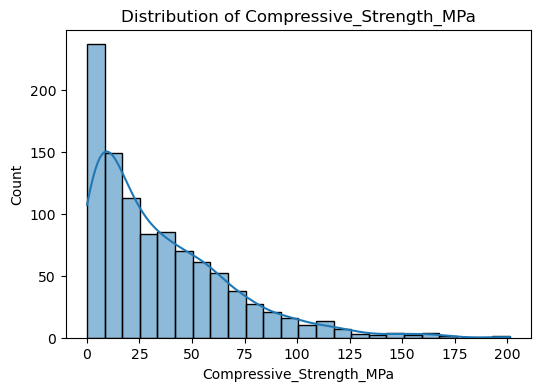

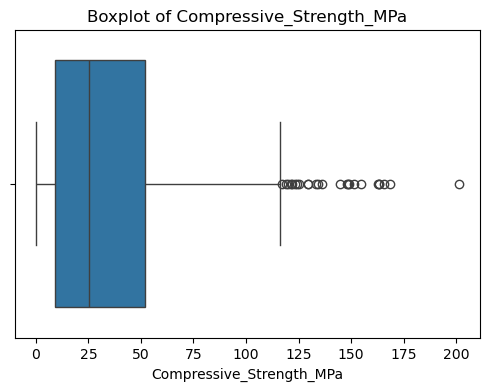

count    1000.000000
mean       34.742131
std        32.371380
min         0.068611
25%         8.945903
50%        25.407167
75%        51.825962
max       201.221114
Name: Compressive_Strength_MPa, dtype: float64


Type `0` to enter a mode or `1` to analyze the dataset:  1


Polymer Dataset Overview:
   E_mix_GPa  K_mix_GPa  rho_mix_g_cm3  Applied_Pressure_MPa  \
0   9.278653   7.545827       1.156509             21.475626   
1   5.205866   5.637345       1.070482             32.990316   
2   4.034806   4.197834       1.013748             43.130364   
3   8.630308   7.184718       0.979855             28.427137   
4   7.884567   6.856853       0.991116             37.744309   

   Press_Hold_Time_hours  Compressive_Strength_MPa  
0               0.104099                 11.861833  
1               0.418581                 35.939091  
2               0.437425                 35.162989  
3               0.470123                 52.893914  
4               0.738767                 95.079599  


Do you want to analyze features? [y/n]:  y


Options:
a: Show Pairplot Between All Features
b: Show Heatmap Between All Features
c: Analyze One Feature
d: Analyze Two Features


 d


Select first feature:
0: E_mix_GPa
1: K_mix_GPa
2: rho_mix_g_cm3
3: Applied_Pressure_MPa
4: Press_Hold_Time_hours
5: Compressive_Strength_MPa


 4


Select second feature:
0: E_mix_GPa
1: K_mix_GPa
2: rho_mix_g_cm3
3: Applied_Pressure_MPa
4: Press_Hold_Time_hours
5: Compressive_Strength_MPa


 5


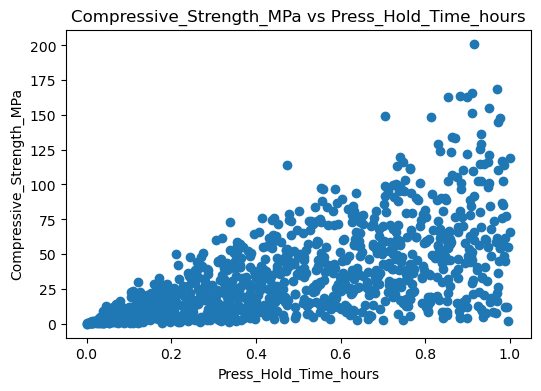

Type `0` to enter a mode or `1` to analyze the dataset:  0
Type `u` for User Interface, `d` for Demo, `r` for Random:  u


User Interface Mode: Enter Applied Pressure, Press Time, and composition for 15 materials.


In [ ]:
# ------------------------
# User Interface Functions
# ------------------------
def modes(show: str):
    pred_cs_list = []
    args = []

    if show.lower() == "u":  # User Input Mode
        print("User Interface Mode: Enter Applied Pressure, Press Time, and composition for 15 materials.")
        P = float(input("Applied Pressure (MPa): "))
        t = float(input("Press Time (hours): "))
        composition = []
        for mat in materials:
            val = float(input(f"Wt% for {mat}: "))
            composition.append(val)
        print(f"Predicted Compressive Strength (MPa): {mix(P, t, composition)}")

    elif show.lower() == "d":  # Demo Mode
        print("Demo Mode: Generating predictions for a few random samples.")
        for _ in range(5):  # 5 demo examples
            P = np.random.uniform(*pressure_range_MPa)
            t = np.random.uniform(*press_time_range_hours)
            composition = np.random.rand(len(materials))
            composition /= composition.sum()  # normalize
            cs_pred = mix(P, t, composition)
            pred_cs_list.append({
                "Applied_Pressure": P,
                "Press_Hold_Time": t,
                **{materials[i]: composition[i] for i in range(len(materials))},
                "Predicted_CS_MPa": cs_pred
            })
        demo_df = pd.DataFrame(pred_cs_list)
        print(demo_df)

    else:  # Random Mode
        print("Random Mode: Generating a single random prediction.")
        P = np.random.uniform(*pressure_range_MPa)
        t = np.random.uniform(*press_time_range_hours)
        composition = np.random.rand(len(materials))
        composition /= composition.sum()  # normalize
        print(f"Random Prediction -> Applied Pressure: {P:.2f} MPa, Press Time: {t:.4f} h")
        print(f"Predicted Compressive Strength (MPa): {mix(P, t, composition)}")

def stats(show: str):
    """
    Analyze the dataset df_materials.
    """
    if show.lower() in ["y", "yes", "n", "no"]:
        print("Options:")
        print("a: Show Pairplot Between All Features")
        print("b: Show Heatmap Between All Features")
        print("c: Analyze One Feature")
        print("d: Analyze Two Features")
        choice = input().lower()

        if choice == "a":
            sns.pairplot(df_materials)
            plt.show()
        elif choice == "b":
            corr = df_materials.corr()
            print(corr)
            sns.heatmap(corr, annot=True)
            plt.show()
        elif choice == "c":
            print("Select a Feature:")
            for i, col in enumerate(df_materials.columns):
                print(f"{i}: {col}")
            idx = int(input())
            col = df_materials.columns[idx]

            plt.figure(figsize=(6, 4))
            sns.histplot(df_materials[col], kde=True)
            plt.title(f"Distribution of {col}")
            plt.show()

            plt.figure(figsize=(6, 4))
            sns.boxplot(x=df_materials[col])
            plt.title(f"Boxplot of {col}")
            plt.show()

            print(df_materials[col].describe())
        elif choice == "d":
            print("Select first feature:")
            for i, col in enumerate(df_materials.columns):
                print(f"{i}: {col}")
            x_idx = int(input())
            x_col = df_materials.columns[x_idx]

            print("Select second feature:")
            for i, col in enumerate(df_materials.columns):
                print(f"{i}: {col}")
            y_idx = int(input())
            y_col = df_materials.columns[y_idx]

            plt.figure(figsize=(6, 4))
            plt.scatter(df_materials[x_col], df_materials[y_col])
            plt.xlabel(x_col)
            plt.ylabel(y_col)
            plt.title(f"{y_col} vs {x_col}")
            plt.show()
        else:
            print("Invalid option. Please select a-d.")

# ------------------------
# Main Program
# ------------------------
def main():
    global choice
    choice = ""
    print("Polymer Compressive Strength Predictor Interface:")
    print("Enter 'q' to quit at any time.")

    while choice.lower() != "q":
        choice = input("Type `0` to enter a mode or `1` to analyze the dataset: ")
        if choice == "0":
            mode_choice = input("Type `u` for User Interface, `d` for Demo, `r` for Random: ").lower()
            if mode_choice in ["u", "d", "r"]:
                modes(mode_choice)
            else:
                print("Invalid mode. Choose u, d, or r.")
        elif choice == "1":
            print("Polymer Dataset Overview:")
            print(df_materials.head())
            stats_choice = input("Do you want to analyze features? [y/n]: ").lower()
            stats(stats_choice)
        else:
            continue

    print("Program Ended.")

# ------------------------
# Execute
# ------------------------
# Execute the main program
main()

# Metadata:
main.info = "Project developed for the NASA Space Apps Challenge."
main.version = "v1.0.0"